In [1]:

#load clean data
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import re
import os
import matplotlib.pyplot as plt

root_dir = os.getcwd()

In [2]:
#backout one level to get to the data
os.chdir('..')
data_dir = os.getcwd()

data = pd.read_csv('data/processed/df_xPassRush.csv')
games_df = pd.read_csv('data/raw/games.csv')

#keep only relevant columns from games_df
games_df = games_df[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]

/var/folders/_g/lng396814dx5ldkl26h6w3y00000gn/T/ipykernel_97815/4291236343.py:5: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/processed/df_xPassRush.csv')


In [3]:
# left join data and games_df on gameId
df = pd.merge(data, games_df, on='gameId', how='left')

In [4]:
# Columns representing the game context
game_context_cols = [
    "gameId",
    "playId",
    "possessionTeam",
    "defensiveTeam",
    "quarter",
    "gameClock",
    "down",
    "yardsToGo",
    "yardlineNumber",
    "yardlineSide",
    "offenseFormation",
    "receiverAlignment",
    "yardsGained",
    'preSnapHomeTeamWinProbability',
    'preSnapVisitorTeamWinProbability',
    'homeTeamAbbr',
    'visitorTeamAbbr',
    'playDescription',
    'passLocationType',
    'pff_runConceptPrimary'
]

# Filter for defensive players only
defensive_players = df[df["club"] != df["possessionTeam"]].copy()

# Add a unique identifier for each position within a play, since there can be multiple players at the same position
defensive_players["positionCount"] = (
    defensive_players.groupby(["gameId", "playId", "position"]).cumcount() + 1
)

# Create a unique column suffix for each player using their position
defensive_players["playerSuffix"] = defensive_players["position"] + defensive_players["positionCount"].astype(str)

# Pivot the defensive player hDist and losDist data
pivoted = defensive_players.pivot_table(
    index=["gameId", "playId"],
    columns="playerSuffix",
    values=["xPassRush"],
    aggfunc="first"
)

# Flatten the multi-level columns 
pivoted.columns = [f"{metric}_{suffix}" for metric, suffix in pivoted.columns]

# Reset index to merge with game context
pivoted.reset_index(inplace=True)

# Extract game context (it doesn't vary within a play)
game_context = defensive_players.drop_duplicates(subset=["gameId", "playId"])[game_context_cols]

# Merge pivoted data with game context
result_df = pd.merge(game_context, pivoted, on=["gameId", "playId"], how="left")

# compare result to original dataframe. It checks out. Since different plays will have different number of each position we generate cols for all and just use NaN for now
# print(result_df.head())
# print(result_df.columns)
# print(df[['nflId', 'playId', 'displayName','position', 'hDist', 'losDist', 'xPassRush']].head(20))
#print the counts of each unique value in the passLocationType column

#drop rows where the pff_runConceptPrimary is UNDEFINED
result_df = result_df[result_df['pff_runConceptPrimary'] != 'UNDEFINED']

#drop rows where the passLocationType is UNKNOWN
result_df = result_df[result_df['passLocationType'] != 'UNKNOWN']

# Define a function to generate the basicPlayDescription per row
def get_basic_play_description(row):
    pass_loc = row['passLocationType']
    run_concept = row['pff_runConceptPrimary']

    if pd.notna(pass_loc) and pd.notna(run_concept):
        # Both are not NaN, prioritize pass (passLocationType)
        return f"play action pass: {pass_loc}"
    elif pd.notna(pass_loc):
        # passLocationType is not NaN
        return f"pass: {pass_loc}"
    elif pd.notna(run_concept):
        # pff_runConceptPrimary is not NaN
        return f"run: {run_concept}"


# Create basicPlayDescription
result_df['basicPlayDescription'] = result_df.apply(get_basic_play_description, axis=1)

#label rows where the basicPlayDescription is none as 'scramble' (confirmed by looking at the playDescription)
result_df['basicPlayDescription'] = result_df['basicPlayDescription'].fillna('scramble')

#now we can drop the passLocationType and pff_runConceptPrimary columns
result_df = result_df.drop(columns=['passLocationType', 'pff_runConceptPrimary'])


In [5]:
# we found model was not differntiating between different types of runs.
groupings = {
    'run: OUTSIDE ZONE': 'ZONE RUN',
    'run: INSIDE ZONE': 'ZONE RUN',
    'run: PULL LEAD': 'POWER RUN',
    'run: POWER': 'POWER RUN',
    'run: TRAP': 'POWER RUN',
    'run: DRAW': 'RUN PLAY',
    'run: COUNTER': 'RUN PLAY',
    'run: FB RUN': 'RUN PLAY',
    'run: TRICK': 'TRICK/MAN',
    'run: MAN': 'TRICK/MAN',
    # Other descriptions remain unchanged or are labeled as 'UNDEFINED'
}

# Apply the mapping and leave other values unchanged
result_df['basicPlayDescription'] = result_df['basicPlayDescription'].apply(
    lambda x: groupings.get(x, x)
)

In [6]:
print(result_df['basicPlayDescription'].unique())

['pass: INSIDE_BOX' 'scramble' 'ZONE RUN' 'POWER RUN'
 'pass: OUTSIDE_RIGHT' 'play action pass: OUTSIDE_RIGHT'
 'play action pass: INSIDE_BOX' 'TRICK/MAN'
 'play action pass: OUTSIDE_LEFT' 'pass: OUTSIDE_LEFT' 'RUN PLAY']


In [7]:
# Using this result, we should generate the "WinProbabilityAdded" as a target column. Recognize the PlayId is not ordered.
# Ensure the data is sorted by gameId and playId
df = result_df.sort_values(by=["gameId", "playId"]).reset_index(drop=True)

# Shift the win probability columns to get the next play's values
df["nextHomeWinProbability"] = df.groupby("gameId")["preSnapHomeTeamWinProbability"].shift(-1)

# Compute the added win probability for each play, we need only to predict this, since the addedVisitorWinProbability will just be the same value with opposite sign.
df["addedHomeWinProbability"] = df["nextHomeWinProbability"] - df["preSnapHomeTeamWinProbability"]

# Drop the temporary "next" columns
df = df.drop(columns=["nextHomeWinProbability"])

#replace NaNs with 0 in 'addedHomeWinProbability' last play of the game, actually not really sure the best way to handle these NaNs but we can't have NaNs in the target column
df['addedHomeWinProbability'] = df['addedHomeWinProbability'].fillna(0)

# Inspect the updated DataFrame
# print(df[["gameId", "playId", 'gameClock', 'down','yardsGained','yardlineNumber', "preSnapHomeTeamWinProbability", 
#           "addedHomeWinProbability"]].head(20))

# Function to calculate yards to the end zone
def calculate_yards_to_endzone(row):
    if row["yardlineSide"] == row["possessionTeam"]:
        # Driving towards the opponent's end zone
        return 100 - row["yardlineNumber"]
    else:
        # Driving towards their own end zone
        return row["yardlineNumber"]

# Apply the function to create the new column
df["yardsToTD"] = df.apply(calculate_yards_to_endzone, axis=1)


In [8]:
# Specify the target columns
target_yards = "yardsGained"
target_win_prob = "addedHomeWinProbability"

# specify relevant columns
cols_to_drop = [
    #  'quarter',
    #  'gameClock',
    #  'down',
    #  'yardsToGo',
    #  'yardlineNumber', 
    #  'preSnapHomeTeamWinProbability', 
    #  'preSnapVisitorTeamWinProbability'
        'gameId',
        'yardlineSide',
        'playId',
        'possessionTeam',
        'defensiveTeam',
        'homeTeamAbbr',
        'playDescription',
        'visitorTeamAbbr',
        'offenseFormation', 
        'receiverAlignment',
        ]

df_clean = df.drop(cols_to_drop, axis=1)

In [9]:
# Function to convert MM:SS format to float (total seconds)
def convert_game_clock_to_seconds(clock):
    minutes, seconds = map(int, clock.split(":"))
    return minutes * 60 + seconds


# Apply the conversion function to the gameClock column
df_clean['gameClock'] = df_clean['gameClock'].apply(convert_game_clock_to_seconds).astype(float)

In [10]:
df = df_clean

# Separate categorical and numeric features
categorical_features = df.select_dtypes(include=["object", "category"]).columns
numeric_features = df.select_dtypes(include=["number"]).drop([target_yards, target_win_prob], axis=1).columns

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_categorical = encoder.fit_transform(df[categorical_features])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

# Combine numeric and encoded categorical features
X = pd.concat([df[numeric_features], encoded_categorical_df], axis=1)

In [11]:
# Target variables
y_yards = df[target_yards]
y_win_prob = df[target_win_prob]

# Lists to store feature importances for each fold
yards_feature_importances = []
win_prob_feature_importances = []

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 5]
}

# Perform KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
yards_mse_scores = []
win_prob_mse_scores = []

# Perform k-fold CV
for train_index, test_index in kf.split(X):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_yards, y_test_yards = y_yards.iloc[train_index], y_yards.iloc[test_index]
    y_train_win_prob, y_test_win_prob = y_win_prob.iloc[train_index], y_win_prob.iloc[test_index]

    # Initialize XGBoost regressor
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

    # 1) Hyperparameter tuning for yards
    grid_search_yards = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        scoring="neg_root_mean_squared_error",
        cv=10,  # Inner cross-validation for hyperparameter tuning
        random_state=42,
        n_jobs=-1
    )
    grid_search_yards.fit(X_train, y_train_yards)

    # Best estimator for yardsGained
    best_model_yards = grid_search_yards.best_estimator_

    # 2) Hyperparameter tuning for win probability
    grid_search_win_prob = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=10,
        random_state=42,
        n_jobs=-1
    )
    grid_search_win_prob.fit(X_train, y_train_win_prob)

    # Best estimator for addedHomeWinProbability
    best_model_win_prob = grid_search_win_prob.best_estimator_

    # Predict on the test set
    y_pred_yards = best_model_yards.predict(X_test)
    y_pred_win_prob = best_model_win_prob.predict(X_test)

    # Evaluate the models
    mse_yards = mean_squared_error(y_test_yards, y_pred_yards)
    mse_win_prob = mean_squared_error(y_test_win_prob, y_pred_win_prob)

    # Store the results
    yards_mse_scores.append(mse_yards)
    win_prob_mse_scores.append(mse_win_prob)

    # Store feature importance arrays for each fold
    yards_feature_importances.append(best_model_yards.feature_importances_)
    win_prob_feature_importances.append(best_model_win_prob.feature_importances_)

# Calculate and display mean and standard deviation of RMSEs
print(f"YardsGained MSE - Mean: {np.mean(yards_mse_scores):.4f}, Std Dev: {np.std(yards_mse_scores):.4f}")
print(f"AddedHomeWinProbability MSE - Mean: {np.mean(win_prob_mse_scores):.4f}, Std Dev: {np.std(win_prob_mse_scores):.4f}")

# Average feature importances across the 5 folds
mean_yards_importances = np.mean(yards_feature_importances, axis=0)
mean_win_prob_importances = np.mean(win_prob_feature_importances, axis=0)

# Create DataFrames for feature importances
feature_names = X.columns  # Ensure X is a DataFrame with named columns

yards_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mean_yards_importances
}).sort_values(by="Importance", ascending=False)

win_prob_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mean_win_prob_importances
}).sort_values(by="Importance", ascending=False)

# Print top feature importances
print("\nTop YardsGained Feature Importances:")
print(yards_importance_df.head(10))

print("\nTop WinProbability Feature Importances:")
print(win_prob_importance_df.head(10))

YardsGained MSE - Mean: 73.5833, Std Dev: 3.7210
AddedHomeWinProbability MSE - Mean: 0.0023, Std Dev: 0.0002

Top YardsGained Feature Importances:
                                              Feature  Importance
33                                          yardsToTD    0.065894
41  basicPlayDescription_play action pass: INSIDE_BOX    0.058254
38              basicPlayDescription_pass: INSIDE_BOX    0.050231
37                      basicPlayDescription_ZONE RUN    0.045417
10                                      xPassRush_CB4    0.034404
26                                     xPassRush_OLB3    0.033880
15                                      xPassRush_DE4    0.030183
44                      basicPlayDescription_scramble    0.029282
39            basicPlayDescription_pass: OUTSIDE_LEFT    0.029217
27                                     xPassRush_OLB4    0.029033

Top WinProbability Feature Importances:
                             Feature  Importance
0                            quarter 

In [15]:
# Define function to compute average difference for given play type change
def compute_avg_difference(X, model, from_play, to_play, mask=None):
    # Apply mask if provided
    if mask is not None:
        X = X[mask]
    
    # Filter for basicPlayDescription columns
    desc_cols = [col for col in X.columns if col.startswith("basicPlayDescription")]
    
    # Create a copy to avoid modifying the original dataset
    X_copy = X.copy()
    
    # Store differences
    differences = []
    for idx in range(len(X_copy)):
        single_play = X_copy.iloc[[idx]].copy()
        
        # Predict original yardsGained
        original_yards_pred = model.predict(single_play)[0]
        
        # Set all basicPlayDescription columns to 0
        single_play[desc_cols] = 0
        
        # Set "from_play" column to 1
        single_play[from_play] = 1
        
        # Predict yardsGained for the original "from_play"
        original_yards_pred = model.predict(single_play)[0]
        
        # Set all basicPlayDescription columns to 0 again
        single_play[desc_cols] = 0
        
        # Set "to_play" column to 1
        single_play[to_play] = 1
        
        # Predict yardsGained for the "to_play"
        new_yards_pred = model.predict(single_play)[0]
        
        # Compute difference
        differences.append(new_yards_pred - original_yards_pred)

    return differences


# Define play types to compare
from_play = "basicPlayDescription_play action pass: OUTSIDE_LEFT"
to_play = "basicPlayDescription_ZONE RUN"

differences = compute_avg_difference(X_test, best_model_yards, from_play, to_play)
# Compare for all plays
avg_difference_all = np.mean(differences)


In [16]:
print(X.columns)

Index(['quarter', 'gameClock', 'down', 'yardsToGo', 'yardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'xPassRush_CB1', 'xPassRush_CB2', 'xPassRush_CB3', 'xPassRush_CB4',
       'xPassRush_CB5', 'xPassRush_DE1', 'xPassRush_DE2', 'xPassRush_DE3',
       'xPassRush_DE4', 'xPassRush_IDL1', 'xPassRush_IDL2', 'xPassRush_IDL3',
       'xPassRush_IDL4', 'xPassRush_ILB1', 'xPassRush_ILB2', 'xPassRush_ILB3',
       'xPassRush_ILB4', 'xPassRush_OLB1', 'xPassRush_OLB2', 'xPassRush_OLB3',
       'xPassRush_OLB4', 'xPassRush_S1', 'xPassRush_S2', 'xPassRush_S3',
       'xPassRush_S4', 'xPassRush_S5', 'yardsToTD',
       'basicPlayDescription_POWER RUN', 'basicPlayDescription_RUN PLAY',
       'basicPlayDescription_TRICK/MAN', 'basicPlayDescription_ZONE RUN',
       'basicPlayDescription_pass: INSIDE_BOX',
       'basicPlayDescription_pass: OUTSIDE_LEFT',
       'basicPlayDescription_pass: OUTSIDE_RIGHT',
       'basicPlayDescription_play action pass:

In [17]:
plays=[ 
'basicPlayDescription_pass: INSIDE_BOX',
'basicPlayDescription_pass: OUTSIDE_LEFT',
'basicPlayDescription_pass: OUTSIDE_RIGHT',
'basicPlayDescription_play action pass: INSIDE_BOX',
'basicPlayDescription_play action pass: OUTSIDE_LEFT',
'basicPlayDescription_play action pass: OUTSIDE_RIGHT',
'basicPlayDescription_scramble',
'basicPlayDescription_ZONE RUN',
'basicPlayDescription_POWER RUN',
'basicPlayDescription_RUN PLAY'
]

# Function to compare all play types for a subset of rows
def compare_play_types(X, model, plays, subset_rows=5):
    # Take a subset of rows
    X_subset = X.iloc[:subset_rows].copy()
    
    # Filter for basicPlayDescription and xPassRush columns
    desc_cols = [col for col in X_subset.columns if col.startswith("basicPlayDescription")]
    pass_rush_cols = [col for col in X_subset.columns if col.startswith("xPassRush")]
    
    # Initialize a DataFrame to store results
    results = pd.DataFrame(columns=["Play", "Label", "xYardsGained"])
    
    # Iterate through each row and each play type
    for idx in range(len(X_subset)):
        single_play = X_subset.iloc[[idx]].copy()
        
        # Create a label for the row using game context columns and count of xPassRush > 0.6
        game_context = single_play[["yardsToGo", "quarter", "down", "gameClock", "yardsToTD"]]
        num_pass_rush = (single_play[pass_rush_cols] > 0.6).sum(axis=1).values[0]
        label = (
            f"YTFD:{game_context['yardsToGo'].values[0]}, "
            f"Q:{game_context['quarter'].values[0]}, "
            f"D:{game_context['down'].values[0]}, "
            f"GC:{game_context['gameClock'].values[0]}, "
            f"YTTD:{game_context['yardsToTD'].values[0]}, "
            f"xPassRush > 0.6: {num_pass_rush}"
        )

        # print out the play label and the corresponding columns that begin with "xPassRush_"
        # print(label)
        # print(single_play[pass_rush_cols].T)

        
        for play in plays:
            # Reset all basicPlayDescription columns to 0
            single_play[desc_cols] = 0
            
            # Set the current play type to 1
            single_play[play] = 1
            
            # Predict yardsGained
            predicted_yards = model.predict(single_play)[0]
            
            # Append result
            results = pd.concat(
                [results, pd.DataFrame({"Play": [play], "Label": [label], "xYardsGained": [predicted_yards]})],
                ignore_index=True
            )
    
    return results

YTFD:3, Q:1, D:3, GC:568.0, YTTD:68, xPassRush > 0.6: 5
                      98
xPassRush_CB1   0.000016
xPassRush_CB2   0.111172
xPassRush_CB3   0.000548
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1   0.999914
xPassRush_DE2        NaN
xPassRush_DE3        NaN
xPassRush_DE4        NaN
xPassRush_IDL1  0.997171
xPassRush_IDL2       NaN
xPassRush_IDL3       NaN
xPassRush_IDL4       NaN
xPassRush_ILB1  0.422271
xPassRush_ILB2       NaN
xPassRush_ILB3       NaN
xPassRush_ILB4       NaN
xPassRush_OLB1  0.953172
xPassRush_OLB2  0.965756
xPassRush_OLB3  0.979152
xPassRush_OLB4       NaN
xPassRush_S1    0.023913
xPassRush_S2    0.000042
xPassRush_S3         NaN
xPassRush_S4         NaN
xPassRush_S5         NaN
YTFD:3, Q:1, D:3, GC:566.0, YTTD:36, xPassRush > 0.6: 4
                     206
xPassRush_CB1   0.000191
xPassRush_CB2   0.001908
xPassRush_CB3        NaN
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1        NaN
xPassRush_DE2        NaN
xPassRush_DE3

/var/folders/_g/lng396814dx5ldkl26h6w3y00000gn/T/ipykernel_97815/3695007001.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(


YTFD:1, Q:4, D:3, GC:34.0, YTTD:31, xPassRush > 0.6: 4
                     512
xPassRush_CB1   0.011193
xPassRush_CB2   0.002864
xPassRush_CB3   0.014425
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1        NaN
xPassRush_DE2        NaN
xPassRush_DE3        NaN
xPassRush_DE4        NaN
xPassRush_IDL1  0.999976
xPassRush_IDL2  0.999961
xPassRush_IDL3       NaN
xPassRush_IDL4       NaN
xPassRush_ILB1  0.063020
xPassRush_ILB2       NaN
xPassRush_ILB3       NaN
xPassRush_ILB4       NaN
xPassRush_OLB1  0.967362
xPassRush_OLB2  0.936297
xPassRush_OLB3       NaN
xPassRush_OLB4       NaN
xPassRush_S1    0.000105
xPassRush_S2    0.122946
xPassRush_S3    0.000005
xPassRush_S4         NaN
xPassRush_S5         NaN
YTFD:3, Q:5, D:3, GC:321.0, YTTD:33, xPassRush > 0.6: 4
                     523
xPassRush_CB1   0.001827
xPassRush_CB2   0.000709
xPassRush_CB3   0.342285
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1        NaN
xPassRush_DE2        NaN
xPassRush_DE3 

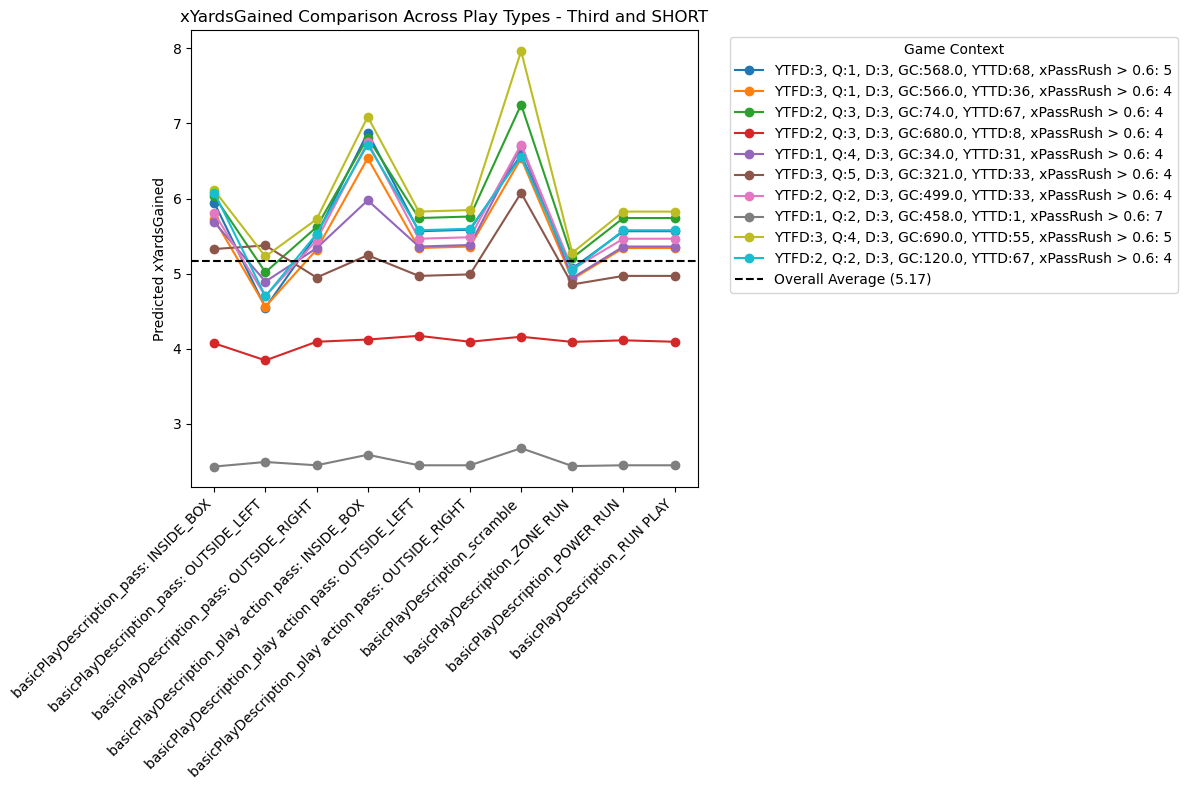

In [18]:
# Filter for 3rd and short plays
third_and_short = X_test[(X_test['down'] == 3) & (X_test['yardsToGo'] <= 3)]

# Use the function to compare play types
results_short = compare_play_types(third_and_short, best_model_yards, plays, subset_rows=10)

# Visualization for 3rd and SHORT
plt.figure(figsize=(12, 8))

# Plot each game's context
for label in results_short["Label"].unique():
    row_data = results_short[results_short["Label"] == label]
    plt.plot(row_data["Play"], row_data["xYardsGained"], marker="o", label=label)

# Calculate the overall average across all play types and samples
overall_average_short = results_short["xYardsGained"].mean()

# Add a horizontal line for the overall average
plt.axhline(y=overall_average_short, color="black", linestyle="--", label=f"Overall Average ({overall_average_short:.2f})")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted xYardsGained")
plt.title("xYardsGained Comparison Across Play Types - Third and SHORT")
plt.legend(title="Game Context", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

YTFD:7, Q:4, D:3, GC:900.0, YTTD:53, xPassRush > 0.6: 4
                      78
xPassRush_CB1   0.000122
xPassRush_CB2   0.006197
xPassRush_CB3   0.000002
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1   0.989083
xPassRush_DE2        NaN
xPassRush_DE3        NaN
xPassRush_DE4        NaN
xPassRush_IDL1  0.999952
xPassRush_IDL2  0.999094
xPassRush_IDL3       NaN
xPassRush_IDL4       NaN
xPassRush_ILB1  0.151054
xPassRush_ILB2  0.571837
xPassRush_ILB3       NaN
xPassRush_ILB4       NaN
xPassRush_OLB1  0.971252
xPassRush_OLB2       NaN
xPassRush_OLB3       NaN
xPassRush_OLB4       NaN
xPassRush_S1    0.000007
xPassRush_S2    0.000041
xPassRush_S3         NaN
xPassRush_S4         NaN
xPassRush_S5         NaN
YTFD:8, Q:2, D:3, GC:847.0, YTTD:54, xPassRush > 0.6: 4
                     224
xPassRush_CB1   0.028494
xPassRush_CB2   0.000194
xPassRush_CB3   0.001970
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1        NaN
xPassRush_DE2        NaN
xPassRush_DE3

/var/folders/_g/lng396814dx5ldkl26h6w3y00000gn/T/ipykernel_97815/3695007001.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(


YTFD:11, Q:4, D:3, GC:80.0, YTTD:15, xPassRush > 0.6: 4
                     301
xPassRush_CB1   0.000121
xPassRush_CB2   0.003840
xPassRush_CB3   0.000762
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1   0.999891
xPassRush_DE2        NaN
xPassRush_DE3        NaN
xPassRush_DE4        NaN
xPassRush_IDL1  0.999791
xPassRush_IDL2  0.999972
xPassRush_IDL3       NaN
xPassRush_IDL4       NaN
xPassRush_ILB1  0.059208
xPassRush_ILB2       NaN
xPassRush_ILB3       NaN
xPassRush_ILB4       NaN
xPassRush_OLB1  0.876701
xPassRush_OLB2  0.585881
xPassRush_OLB3       NaN
xPassRush_OLB4       NaN
xPassRush_S1    0.000012
xPassRush_S2    0.012294
xPassRush_S3         NaN
xPassRush_S4         NaN
xPassRush_S5         NaN
YTFD:7, Q:2, D:3, GC:862.0, YTTD:91, xPassRush > 0.6: 4
                     329
xPassRush_CB1   0.000081
xPassRush_CB2   0.000090
xPassRush_CB3   0.000261
xPassRush_CB4        NaN
xPassRush_CB5        NaN
xPassRush_DE1   0.912392
xPassRush_DE2   0.987297
xPassRush_DE3

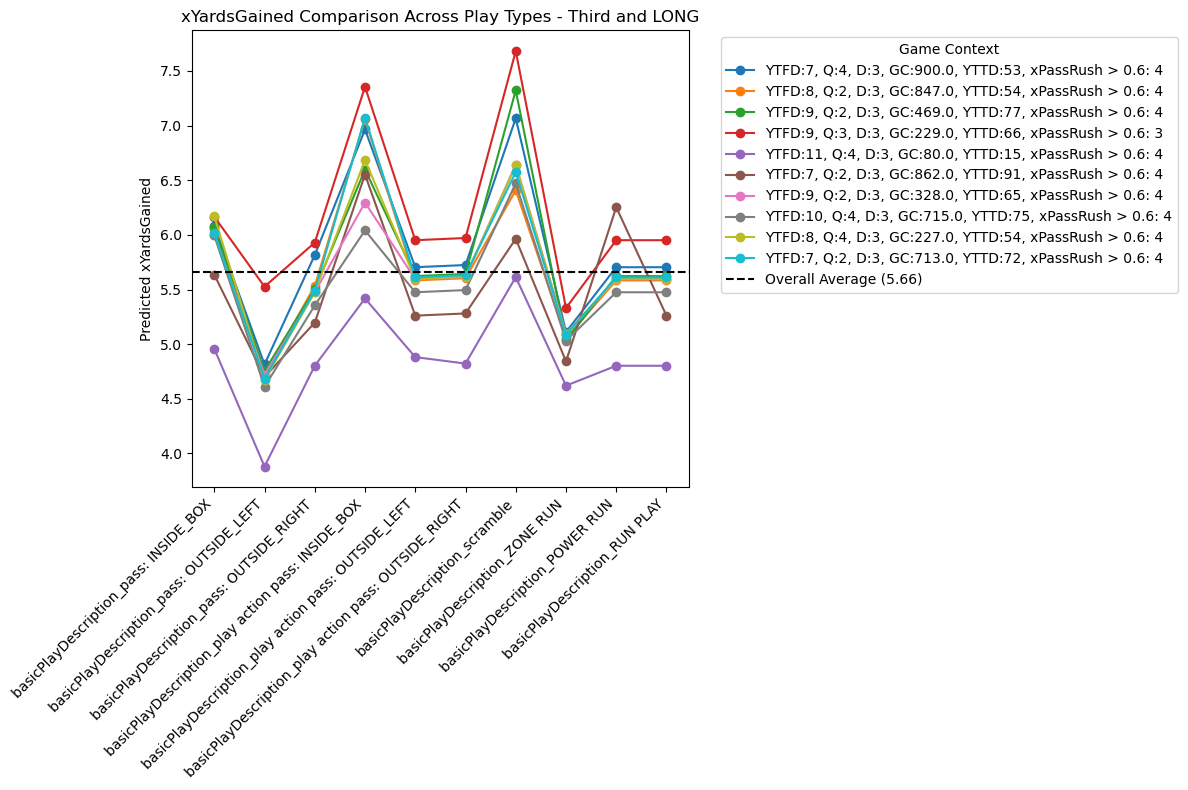

In [19]:
# Filter for 3rd and long plays
third_and_long = X_test[(X_test['down'] == 3) & (X_test['yardsToGo'] >= 7)]

# Use the function to compare play types
results_long = compare_play_types(third_and_long, best_model_yards, plays, subset_rows=10)

# Visualization for 3rd and LONG
plt.figure(figsize=(12, 8))

# Plot each game's context
for label in results_long["Label"].unique():
    row_data = results_long[results_long["Label"] == label]
    plt.plot(row_data["Play"], row_data["xYardsGained"], marker="o", label=label)

# Calculate the overall average across all play types and samples
overall_average_long = results_long["xYardsGained"].mean()

# Add a horizontal line for the overall average
plt.axhline(y=overall_average_long, color="black", linestyle="--", label=f"Overall Average ({overall_average_long:.2f})")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted xYardsGained")
plt.title("xYardsGained Comparison Across Play Types - Third and LONG")
plt.legend(title="Game Context", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


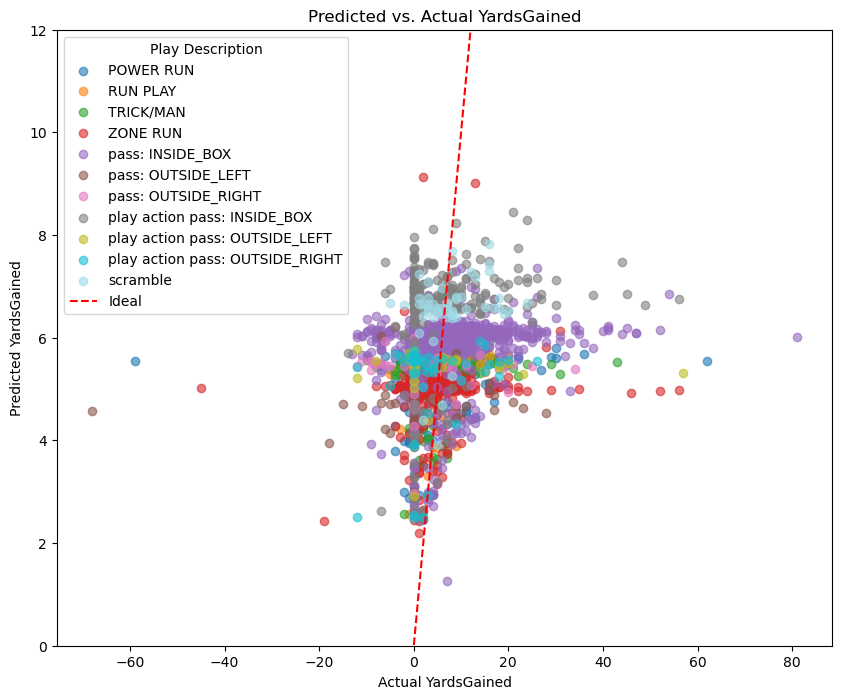

In [20]:
# Visualize predicted vs. actual yardsGained, colored by basicPlayDescription
basic_play_descriptions = df.loc[y_test_yards.index, 'basicPlayDescription'].astype('category')
unique_labels = basic_play_descriptions.cat.categories
colors = basic_play_descriptions.cat.codes

# Generate unique colors for each category
unique_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
category_color_map = {label: unique_colors[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(10, 8))
for label in unique_labels:
    label_mask = basic_play_descriptions == label
    plt.scatter(
        y_test_yards[label_mask], 
        y_pred_yards[label_mask], 
        color=category_color_map[label], 
        label=label, 
        alpha=0.6
    )

plt.plot([y_test_yards.min(), y_test_yards.max()], [y_test_yards.min(), y_test_yards.max()], 'r--', label="Ideal")
plt.xlabel("Actual YardsGained")
plt.ylabel("Predicted YardsGained")
plt.title("Predicted vs. Actual YardsGained")
plt.ylim(0, 12)
plt.legend(title="Play Description")
plt.show()



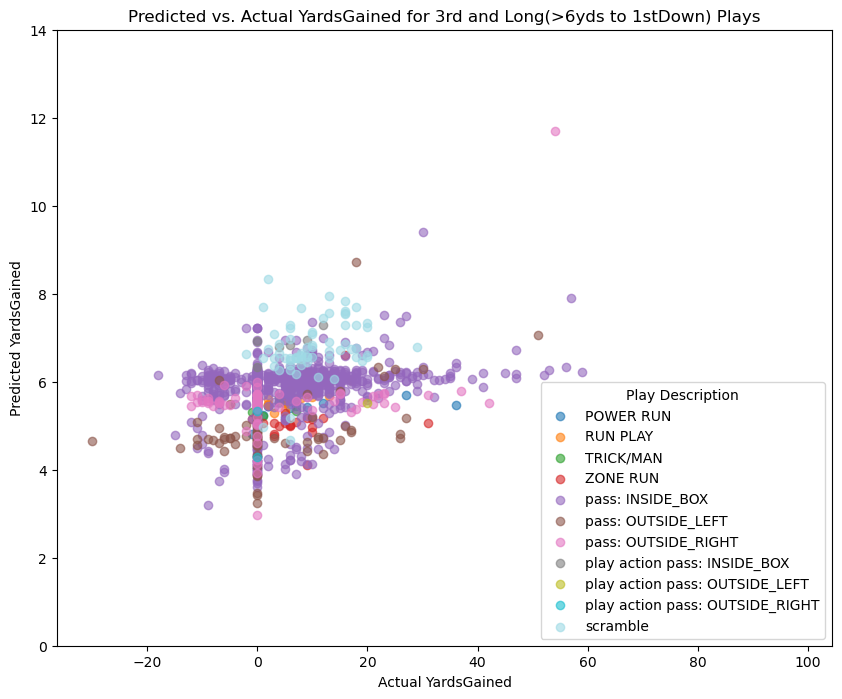

In [21]:
# Filter for 3rd and long plays
third_and_long_mask = (df['down'] == 3) & (df['yardsToGo'] > 6)
X_third_and_long = X.loc[third_and_long_mask]
y_test_yards_third_and_long = y_yards.loc[third_and_long_mask]
y_pred_yards_third_and_long = best_model_yards.predict(X_third_and_long)

# Visualize predicted vs. actual yardsGained for 3rd and long plays
basic_play_descriptions_third_and_long = df.loc[third_and_long_mask, 'basicPlayDescription'].astype('category')
unique_labels_third_and_long = basic_play_descriptions_third_and_long.cat.categories
colors_third_and_long = basic_play_descriptions_third_and_long.cat.codes

plt.figure(figsize=(10, 8))
for label in unique_labels_third_and_long:
    label_mask = basic_play_descriptions_third_and_long == label
    plt.scatter(
        y_test_yards_third_and_long[label_mask], 
        y_pred_yards_third_and_long[label_mask], 
        color=category_color_map[label], 
        label=label, 
        alpha=0.6
    )

#plt.plot([y_test_yards_third_and_long.min(), y_test_yards_third_and_long.max()], [y_test_yards_third_and_long.min(), y_test_yards_third_and_long.max()], 'r--', label="Ideal")
plt.xlabel("Actual YardsGained")
plt.ylabel("Predicted YardsGained")
plt.title("Predicted vs. Actual YardsGained for 3rd and Long(>6yds to 1stDown) Plays")
plt.ylim(0, 14)
plt.legend(title="Play Description")
plt.show()


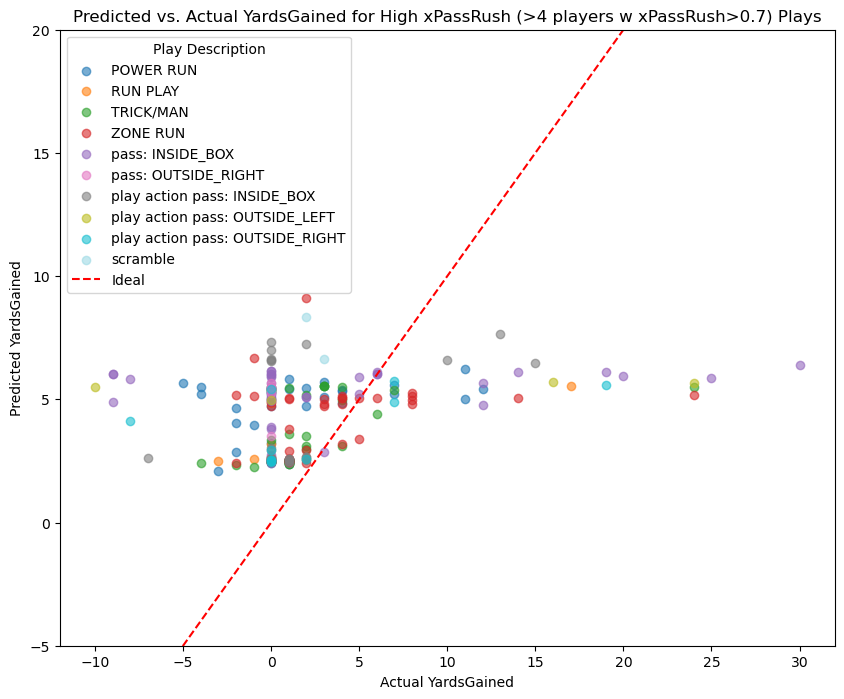

In [22]:

# Filter for plays with more than 5 columns starting with xPassRush_ having values > 0.8
xpassrush_columns = [col for col in df.columns if col.startswith('xPassRush_')]
pass_rush_mask = (df[xpassrush_columns] > 0.7).sum(axis=1) > 5
X_pass_rush = X.loc[pass_rush_mask]
y_test_yards_pass_rush = y_yards.loc[pass_rush_mask]
y_pred_yards_pass_rush = best_model_yards.predict(X_pass_rush)

# Visualize predicted vs. actual yardsGained for high xPassRush plays
basic_play_descriptions_pass_rush = df.loc[pass_rush_mask, 'basicPlayDescription'].astype('category')
unique_labels_pass_rush = basic_play_descriptions_pass_rush.cat.categories
colors_pass_rush = basic_play_descriptions_pass_rush.cat.codes

plt.figure(figsize=(10, 8))
for label in unique_labels_pass_rush:
    label_mask = basic_play_descriptions_pass_rush == label
    plt.scatter(
        y_test_yards_pass_rush[label_mask], 
        y_pred_yards_pass_rush[label_mask], 
        color=category_color_map[label], 
        label=label, 
        alpha=0.6
    )

plt.plot([y_test_yards_pass_rush.min(), y_test_yards_pass_rush.max()], [y_test_yards_pass_rush.min(), y_test_yards_pass_rush.max()], 'r--', label="Ideal")
plt.xlabel("Actual YardsGained")
plt.ylabel("Predicted YardsGained")
plt.title("Predicted vs. Actual YardsGained for High xPassRush (>4 players w xPassRush>0.7) Plays")
plt.ylim(-5, 20)
plt.legend(title="Play Description")
plt.show()

